# Vegetation Phenology <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a)


## Background
Phenology is the study of plant and animal life cycles in the context of the seasons.
It can be useful in understanding the life cycle trends of crops and how the growing seasons are affected by changes in climate.
For more information, see the [USGS page on deriving phenology from NDVI time-series](https://www.usgs.gov/land-resources/eros/phenology/science/deriving-phenological-metrics-ndvi?qt-science_center_objects=0#qt-science_center_objects)

## Description

This notebook calculates vegetation phenology changes using Sentinel 2 data.
To detect changes in plant life for Sentinel-2, the script uses either the `Normalized Difference Vegetation Index (NDVI)` or the `Enhanced Vegetation Index (EVI)`, which are common proxies for vegetation growth and health.

The outputs of this notebook can be used to assess differences in agriculture fields over time or space and also allow the assessment of growing states such as planting and harvesting.
This notebook demonstrates the following steps:

1. Load cloud-masked Sentinel 2 data for an area of interest.
2. Calculate the vegetation proxy index (NDVI or EVI).
3. Generate a zonal time series of vegetation health
4. Complete and smooth the vegetation timeseries to remove gaps and noise.
5. Calculate zonal phenology statistics, such as beginning and end of season for each year using `xr_phenology`
6. Calculate per-pixel phenology statistics

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Load key Python packages and supporting functions for the analysis.

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import xarray as xr
import datetime as dt
import os

sys.path.append('../Scripts')
from deafrica_datahandling import load_ard
from deafrica_bandindices import calculate_indices
from deafrica_plotting import display_map, rgb
import deafrica_temporal_statistics as ts

import warnings
warnings.filterwarnings("ignore", "Mean of empty slice")
warnings.simplefilter("ignore", FutureWarning)

%load_ext autoreload
%autoreload 2

### Connect to the datacube

Connect to the datacube so we can access DE Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app='Vegetation_phenology')

### Analysis parameters

The following cell sets important parameters for the analysis:

* `veg_proxy`: Band index to use as a proxy for vegetation health e.g. `NDVI` or `EVI`
* `lat`: The central latitude to analyse (e.g. `-10.6996`).
* `lon`: The central longitude to analyse (e.g. `35.2708`).
* `buffer`: The number of square degrees to load around the central latitude and longitude.
For reasonable loading times, set this as `0.1` or lower.
* `time_range`: The year range to analyse (e.g. `('2019-01', '2019-06')`).



In [3]:
# Set the vegetation proxy to use
veg_proxy = 'NDVI'

# Define area of interest
lat = 22.817
lon = 28.518
lon_buffer = 0.0175
lat_buffer = 0.004

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat-lat_buffer, lat+lat_buffer)
lon_range = (lon-lon_buffer, lon+lon_buffer)

# Set the range of dates for the analysis
years_range = ('2018-01', '2018-06')

## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [4]:
# display_map(x=lon_range, y=lat_range)

## Load cloud-masked Sentinel-2 data

The first step is to load Sentinel-2 data for the specified area of interest and time range. 
The `load_ard` function is used here to load data that has been masked for cloud, shadow and quality filters, making it ready for analysis.

In [5]:
# Create a reusable query
query = {
    'y': lat_range,
    'x': lon_range,
    'time': years_range,
    'measurements': ['red', 'green', 'blue', 'nir'],
    'resolution': (-10,10),
    'output_crs': 'epsg:6933'
}

# Load available data from Landsat 8
ds = load_ard(dc=dc,
              products=['s2_l2a'],
              **query,
              )

print(ds)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying pixel quality/cloud mask
Loading 34 time steps
<xarray.Dataset>
Dimensions:      (time: 34, x: 339, y: 95)
Coordinates:
  * x            (x) float64 2.75e+06 2.75e+06 2.75e+06 ... 2.753e+06 2.753e+06
  * time         (time) datetime64[ns] 2018-01-02T08:53:30 ... 2018-06-26T08:52:59
  * y            (y) float64 2.837e+06 2.837e+06 ... 2.836e+06 2.836e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) float32 1144.0 2486.0 3718.0 ... 4796.0 4784.0
    green        (time, y, x) float32 1001.0 1878.0 2618.0 ... 3232.0 3296.0
    blue         (time, y, x) float32 356.0 941.0 1444.0 ... 2088.0 2088.0
    nir          (time, y, x) float32 4684.0 4784.0 5104.0 ... 5480.0 5460.0
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


**Once the load is complete**, we can plot the data as a true-colour image using the `rgb` function.  

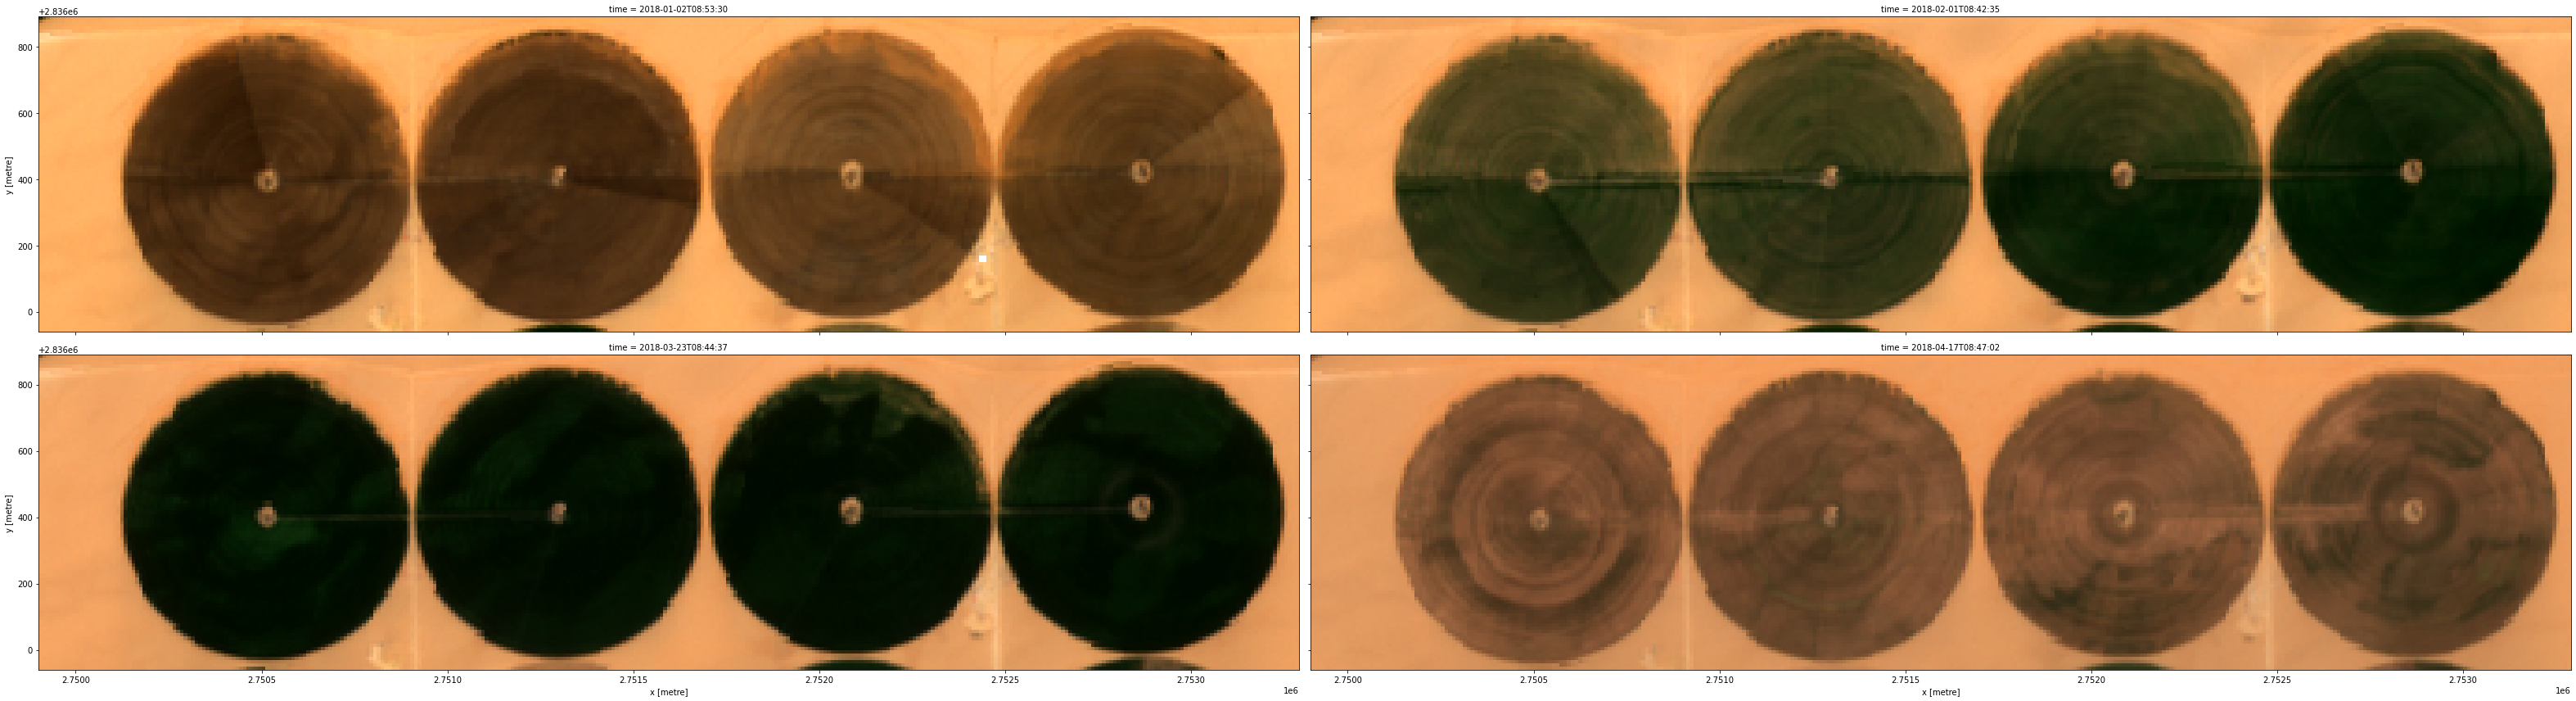

In [6]:
rgb(ds, index=[0,5,15,20], col_wrap=2)

## Compute band indices

This study measures the presence of vegetation through either the `normalised difference vegetation index (NDVI)` or the `enhanced vegetation index (EVI)`.
The index that will be used is dictated by the `veg_proxy` parameter that was set in the "Analysis parameters" section.

The normalised difference vegetation index (NDVI) requires the `red` and `nir` (near-infra red) bands. 
The formula is

$$
\begin{aligned}
\text{NDVI} & = \frac{(\text{NIR} - \text{Red})}{(\text{NIR} + \text{Red})} \\
\end{aligned}
$$

The Enhanced Vegetation Index requires the `red`, `nir` and `blue` bands.
The formula is

$$
\begin{aligned}
\text{EVI} & = \frac{2.5 \times (\text{NIR} - \text{Red})}{(\text{NIR} + 6 \times \text{Red} - 7.5 \times \text{Blue} + 1)} \\
\end{aligned}
$$


Both indices are available through the [calculate_indices](../Frequently_used_code/Calculating_band_indices.ipynb) function, imported from [deafrica_bandindices.py](../Scripts/deafrica_bandindices.py).
Here, we use `collection='s2'` since we're working with Sentinel-2 data.

In [7]:
# Calculate the chosen vegetation proxy index and add it to the loaded data set
ds = calculate_indices(ds, index=veg_proxy, collection='s2')
ds

<xarray.Dataset>
Dimensions:      (time: 34, x: 339, y: 95)
Coordinates:
  * x            (x) float64 2.75e+06 2.75e+06 2.75e+06 ... 2.753e+06 2.753e+06
  * time         (time) datetime64[ns] 2018-01-02T08:53:30 ... 2018-06-26T08:52:59
  * y            (y) float64 2.837e+06 2.837e+06 ... 2.836e+06 2.836e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) float32 1144.0 2486.0 3718.0 ... 4796.0 4784.0
    green        (time, y, x) float32 1001.0 1878.0 2618.0 ... 3232.0 3296.0
    blue         (time, y, x) float32 356.0 941.0 1444.0 ... 2088.0 2088.0
    nir          (time, y, x) float32 4684.0 4784.0 5104.0 ... 5480.0 5460.0
    NDVI         (time, y, x) float32 0.60741246 0.3160935 ... 0.06598986
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

The vegetation proxy index should now appear as a data variable, along with the loaded measurements, in the `ds` object.

## Plot the vegetation index over time

To get an idea of how the vegetation health changes throughout the year(s), we can plot a zonal timeseries over the region of interest. First we will do a simple plot of the zonal mean of the data.  


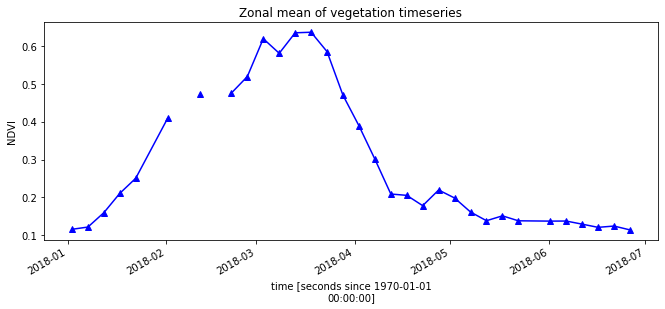

In [8]:
ds.NDVI.mean(['x', 'y']).plot.line('b-^', figsize=(11,4))
plt.title('Zonal mean of vegetation timeseries');

Due to the infrequency of satellite passes or the presence of cloud obscuring the ground, our data may have gaps. `Xarray` has inbuilt methods `.interpolate_na()` to complete a time-series. While these functions are great for small datasets, they can become prohibitively slow at scale. DE Africa's custom function `fast_completion` will remove any `NaNs` (Not a Number) very quickly, even over relatively large datasets. 

#### Interpolate vegetation time-series


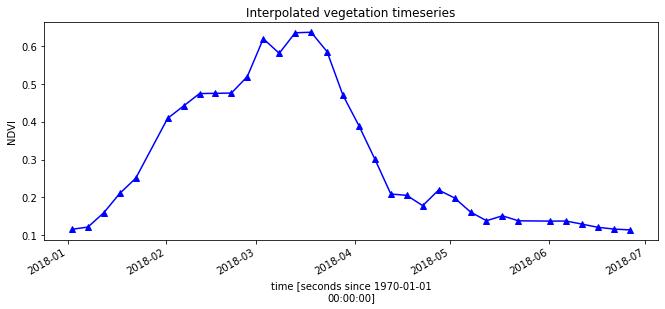

In [9]:
#fill missing values in the NDVI timeseries interpolated values
ds.NDVI.interpolate_na(dim='time', method='linear').mean(['x', 'y']).plot.line('b-^', figsize=(11,4))

plt.title('Interpolated vegetation timeseries');

Alternatively, lets complete the timeseries using the DE Africa function `fast_complete`

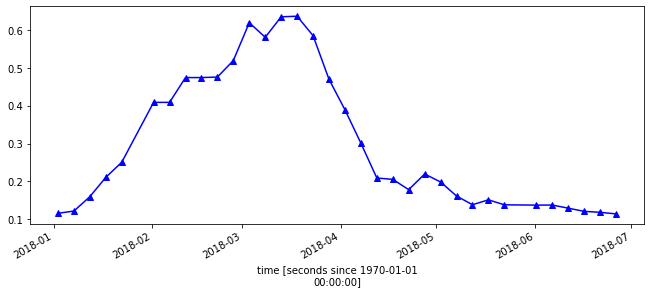

In [10]:
# complete timeseries using fast_completion
ndvi = ts.fast_completion(ds.NDVI)

# plot the result
ndvi.mean(['x','y']).plot.line('b-^', figsize=(11,4))

#### Smooth vegetation time-series

We may also wish to smooth-out a time series. This can be accomplished in a number of ways.
1. By calculating a `rolling mean` over a specified window-size. 
2. By applying the DE Africa custom function `smooth` 

Below we will demostrate how to do this by first calculating a `rolling mean` across every three time steps. The larger the window-size, the smoother the curve will be, but at the cost of more granular detail in the curve.

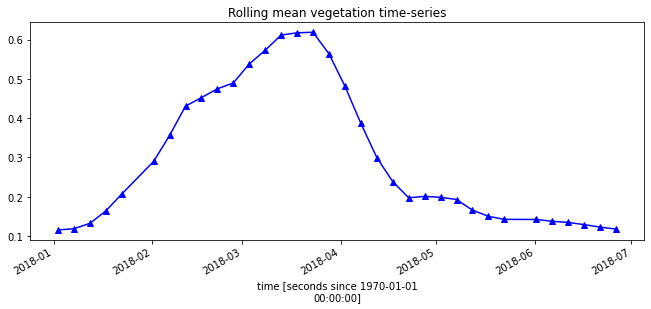

In [11]:
#interpolate the data
ndvi_rolling = ndvi.mean(['x', 'y']).rolling(time=3, min_periods=1).mean()
#plot the interpolated data
ndvi_rolling.plot.line('b-^', figsize=(11,4))
plt.title('Rolling mean vegetation time-series');

 Alternatively, lets smooth the timeseries using the DE Africa function `smooth`

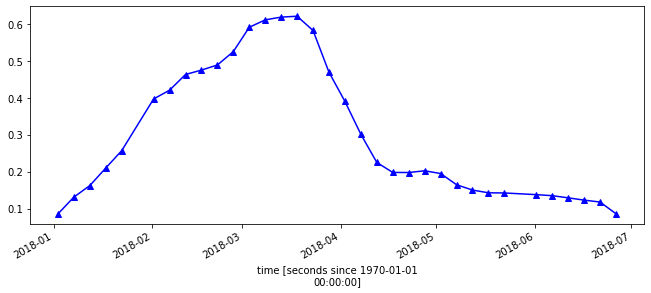

In [12]:
ndvi_smooth = ts.smooth(ndvi)

ndvi_smooth.mean(['x', 'y']).plot.line('b-^', figsize=(11,4))

## Calculate phenology statistics using `xr_phenology`

The DE Africa function `xr_phenology` can caluclate a number of land-surface phenology statistics that together describe the characteristics of a plant's lifecycle.  The function can calculate the following statistics on either a zonal timeseries (like the one above), or on a per-pixel basis:

            SOS = DOY of start of season
            POS = DOY of peak of season
            EOS = DOY of end of season
            vSOS = Value at start of season
            vPOS = Value at peak of season
            vEOS = Value at end of season
            Trough = Minimum value of season
            LOS = Length of season (DOY)
            AOS = Amplitude of season (in value units)
            ROG = Rate of greening
            ROS = Rate of senescence

where DOY = day-of-year.  By default the function will return all of the statistics as an `xarray.Dataset`, to return only a subset of these statistics pass a list of the desired statistics to the function e.g. `stats=['SOS', 'EOS', 'ROG']`.

The `xr_phenology` function also allows for interpolating and/or smoothing the time-series in the same way as we did above, the interpolating/smoothing will occur before the statistics are calculated.


### Zonal phenology statistics

To help us understand what these statistics refer too, lets first pass the simpler zonal time-series to the function and plot the results on the same curves as above.

In [13]:
#calculate phenology on the zonal mean of the dataset
zonal_phen = ts.xr_phenology(ds.NDVI.mean(['x', 'y']),
                       stats=['SOS', 'POS', 'EOS',
                             'vSOS', 'vPOS', 'vEOS'
                             ], 
                       method_sos="first",
                       method_eos="last",
                       complete_method='linear',
                       smooth_method='rolling_mean'
                   )
zonal_phen

Completing using linear interp...
   Smoothing with rolling mean...
      Phenology...
         POS
         EOS
         vSOS
         vPOS
         vEOS


<xarray.Dataset>
Dimensions:      ()
Coordinates:
    time         datetime64[ns] 2018-01-02T08:53:30
    spatial_ref  int32 6933
Data variables:
    SOS          int16 2
    POS          int16 82
    EOS          int16 177
    vSOS         float32 0.1156383
    vPOS         float32 0.6186268
    vEOS         float32 0.11966675

Plot the results with our statistcs annotated on the plot

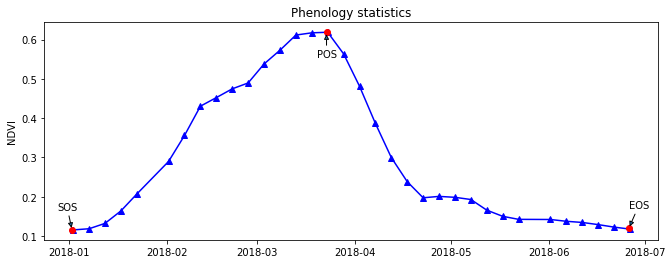

In [14]:
# Use DOY results to create a datetime object 
year = str(zonal_phen.time.dt.year.values) + " "
eos_dt = dt.datetime.strptime(year+str(zonal_phen.EOS.values), '%Y %j')
sos_dt = dt.datetime.strptime(year+str(zonal_phen.SOS.values), '%Y %j')
pos_dt = dt.datetime.strptime(year+str(zonal_phen.POS.values), '%Y %j')

#create plot
fig, ax = plt.subplots(figsize=(11,4))
ax.plot(ndvi_rolling.time,
         ndvi_rolling, 'b-^')

#add start of season
ax.plot(sos_dt, zonal_phen.vSOS, 'or')
ax.annotate('SOS', xy=(sos_dt, zonal_phen.vSOS.values), xytext=(-15, 20),
            textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))

#add end of season
ax.plot(eos_dt, zonal_phen.vEOS, 'or')
ax.annotate('EOS', xy=(eos_dt, zonal_phen.vEOS.values), xytext=(0, 20),
            textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))

#add peak of season
ax.plot(pos_dt, zonal_phen.vPOS, 'or')
ax.annotate('POS', xy=(pos_dt, zonal_phen.vPOS.values), xytext=(-10, -25),
            textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))

plt.ylabel('NDVI')
plt.title('Phenology statistics');

### Per-pixel phenology statistics

In [15]:
#calculate phenology stats on every pixel in dataset
phen = ts.xr_phenology(ds.NDVI,
                    method_sos='median',
                    method_eos='median',
                    complete_method='fast_complete',
                    smooth_method='wiener'
               )
phen

Completing using fast_complete...
   Smoothing with wiener filter...
      Phenology...
         POS
         EOS
         Trough
         vSOS
         vPOS
         vEOS
         LOS
         AOS
         ROG
         ROS


<xarray.Dataset>
Dimensions:  (x: 339, y: 95)
Coordinates:
  * x        (x) float64 2.75e+06 2.75e+06 2.75e+06 ... 2.753e+06 2.753e+06
  * y        (y) float64 2.837e+06 2.837e+06 2.837e+06 ... 2.836e+06 2.836e+06
    time     (y, x) datetime64[ns] 2018-02-06T08:42:29 ... 2018-03-08T08:53:37
Data variables:
    SOS      (y, x) int16 37 37 17 37 37 22 32 22 32 ... 67 72 82 47 72 82 47 67
    POS      (y, x) int16 62 57 62 62 62 62 62 ... 107 107 107 107 107 107 132
    EOS      (y, x) int16 117 127 112 112 77 112 132 ... 162 162 122 142 162 157
    Trough   (y, x) float32 0.06609869 0.056609925 ... 0.049069475 0.04920211
    vSOS     (y, x) float32 0.5318587 0.28643623 ... 0.07734885 0.079120964
    vPOS     (y, x) float32 0.69627666 0.49295738 ... 0.09525073 0.091871016
    vEOS     (y, x) float32 0.10946869 0.09745806 ... 0.08425444 0.08036665
    LOS      (y, x) int16 80 90 95 75 40 90 100 105 ... 85 80 115 50 60 115 90
    AOS      (y, x) float32 0.630178 0.43634745 ... 0.046181254 0.042668905
    ROG      (y, x) float32 0.0065767188 0.010326058 ... 0.00019615461
    ROS      (y, x) float32 -0.010669236 -0.0056499904 ... -0.0004601747

The phenology statistics have been calculated seperately for every pixel in the image.  Let's plot each of them to see the results. 

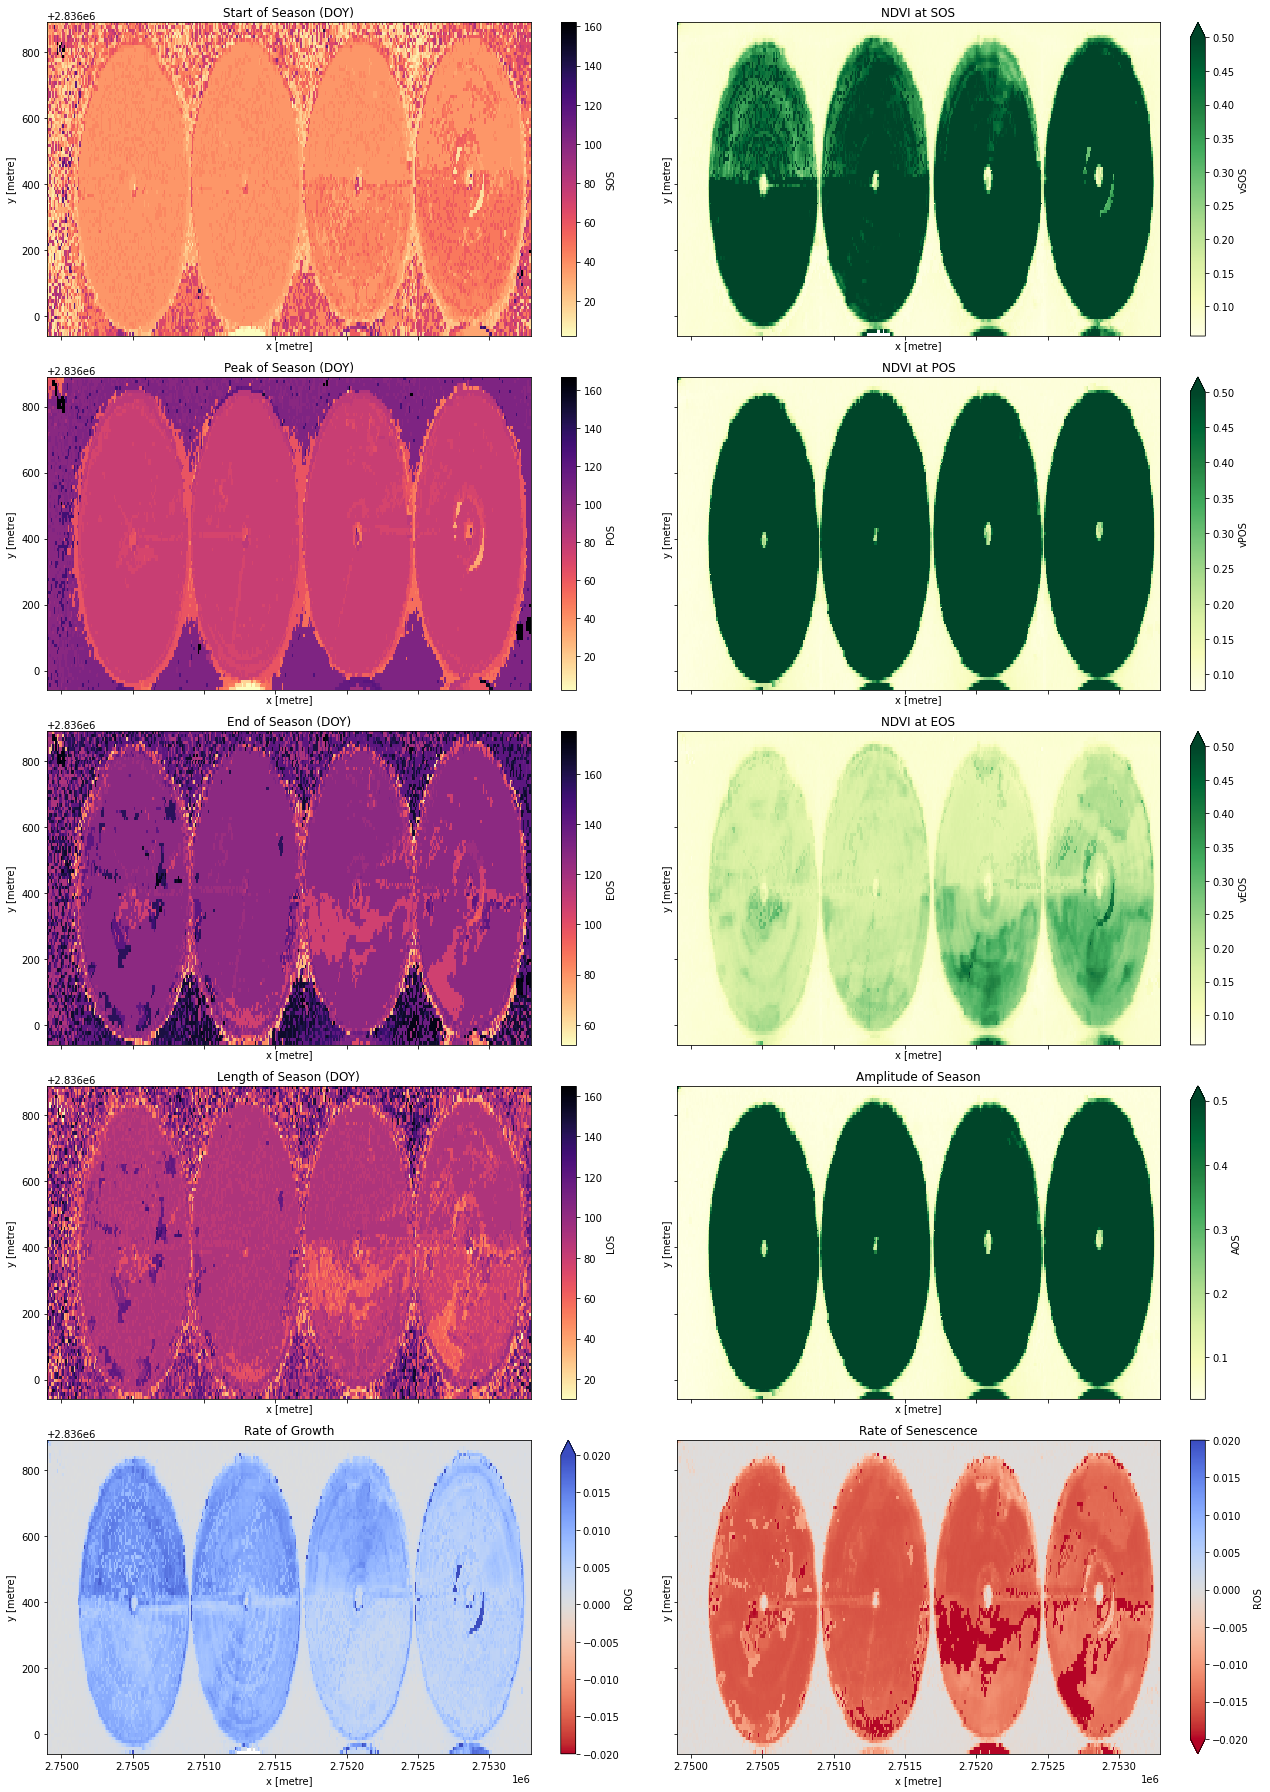

In [16]:
#set up figure
fig, ax = plt.subplots(nrows=5,ncols=2,figsize=(18,25), sharex=True, sharey=True)

#start of season
phen.SOS.plot(ax=ax[0,0], cmap='magma_r')
ax[0,0].set_title('Start of Season (DOY)')
phen.vSOS.plot(ax=ax[0,1], cmap='YlGn', vmax=0.5)
ax[0,1].set_title('NDVI at SOS')

#peak of season
phen.POS.plot(ax=ax[1,0], cmap='magma_r')
ax[1,0].set_title('Peak of Season (DOY)')
phen.vPOS.plot(ax=ax[1,1], cmap='YlGn',vmax=0.5)
ax[1,1].set_title('NDVI at POS')

#end of season
phen.EOS.plot(ax=ax[2,0], cmap='magma_r')
ax[2,0].set_title('End of Season (DOY)')
phen.vEOS.plot(ax=ax[2,1], cmap='YlGn', vmax=0.5)
ax[2,1].set_title('NDVI at EOS')

#Length of Season
phen.LOS.plot(ax=ax[3,0], cmap='magma_r')
ax[3,0].set_title('Length of Season (DOY)');

#Amplitude
phen.AOS.plot(ax=ax[3,1], cmap='YlGn', vmax=0.5)
ax[3,1].set_title('Amplitude of Season')

#rate of growth
phen.ROG.plot(ax=ax[4,0],cmap='coolwarm_r', vmin=-0.02, vmax=0.02)
ax[4,0].set_title('Rate of Growth')

#rate of Sensescence
phen.ROS.plot(ax=ax[4,1],cmap='coolwarm_r', vmin=-0.02, vmax=0.02)
ax[4,1].set_title('Rate of Senescence')

plt.tight_layout();

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** April 2020

**Compatible datacube version:** 

In [17]:
print(datacube.__version__)

1.8.0


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)